# Tau PT Regression + JetID Classification Merge

In this notebook we will implement a NN that merges the regression and classification NN that we developed for pT regression and jetID, respectively.

In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/merged_pt_regress_jet_ID.h5'

2023-07-04 11:15:04.542440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 11:15:04.639667: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 11:15:04.642728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-04 11:15:04.642743: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [2]:
# #You only need to run this once
# def create_training_data_pT_regression(dir_path, test_index=400000):
#     '''
#     test_index: 400000 
#     All the data before test_index are used for training. And all the data after it is used for testing.
#     '''
    
#     #Might have to change the version for other ntuple files
#     data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    
#     inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#     print(inputs)
#     truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[:test_index]
#     reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#     deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
#     eta = data['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
#     selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_train = np.nan_to_num(np.asarray(inputs[selection]))
#     y_train = np.asarray(truth_pt[selection]/reco_pt[selection])
    
#     X_train[abs(X_train) > 1e+9] = 0.

#     np.save(dir_path+"/X_train.npy", X_train)
#     np.save(dir_path+"/y_train.npy", y_train)
# print(create_training_data_pT_regression("../../ntuples/Jan_25_2023"))
# X_train_pT_regress = np.load("../../ntuples/Jan_25_2023/X_train.npy")
# y_train_pT_regress = np.load("../../ntuples/Jan_25_2023/y_train.npy")
# print(X_train_pT_regress)
# print(y_train_pT_regress)

In [3]:
# def make_weights(sig_pt, reco_bkg_pt, pt_edges = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,2000]):
    
#     weight_pt_bkg = np.zeros(reco_bkg_pt.shape)
    
#     sig_hist, sig_bin_edges = np.histogram(sig_pt, bins = pt_edges)
#     bkg_hist, bkg_bin_edges = np.histogram(reco_bkg_pt, bins = pt_edges)
    
#     scale_factor = [sig_hist[i]/bkg_hist[i] for i in range(len(sig_bin_edges)-1)]
    
#     #Assign the weights to qcd jets
#     for i in range(len(sig_bin_edges)-1):
#         weight_pt_bkg[(reco_bkg_pt >= sig_bin_edges[i]) & (reco_bkg_pt < sig_bin_edges[i+1])] = scale_factor[i]
    
#     #weight_pt_bkg[reco_bkg_pt > 100] = weight_pt_bkg[reco_bkg_pt > 100]/2. #Give less weights for high pT background (v4)
    
#     weight_pt_sig = np.ones(sig_pt.shape)
#     weight_pt_sig[sig_pt > 100.] = 2 #Give more importance to high pT signal (v2 + v3)
# #     weight_pt_sig[sig_pt > 120.] = 5. #Give more importance to high pT signal (v3)
#     all_weight = np.concatenate([weight_pt_sig, weight_pt_bkg])
    
#     return all_weight

# def create_training_data_jetID(dir_path):
    
#     pt_edges = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,2000]
    
#     #Might have to change the version for other ntuple files
#     sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
#     bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
#     qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
#     sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
#     bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
#     qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()
    
#     truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000])
#     truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:400000])
#     truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
    
#     reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:400000]
#     deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:400000]
#     eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:400000]
#     #selection_sig = (truth_pt_sig > 20.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#     selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#     y_sig_pT = truth_pt_sig[selection_sig]
    
#     reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:400000]
#     selection_bkg = reco_pt_bkg > 20.
#     y_bkg_pT = truth_pt_bkg[selection_bkg]
    
#     reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
#     selection_qcd = reco_pt_qcd > 20.
#     y_qcd_pT = truth_pt_qcd[selection_qcd]
    
#     #Maybe better to use 2.4 for eta
    
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
#     y_sig = np.full(X_sig.shape[0], 1.)
#     sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
#     X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
#     y_bkg = np.full(X_bkg.shape[0], 0.)
#     bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
#     X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
#     y_qcd = np.full(X_qcd.shape[0], 0.)
#     qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
#     background_pt = np.concatenate([bkg_pt, qcd_pt])
#     print(y_sig, y_bkg, y_qcd)
#     X_train = np.concatenate([X_sig, X_bkg, X_qcd])
#     y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pt, y_qcd_pT / qcd_pt])
#     pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
#     sample_weight = make_weights(sig_pt, background_pt, pt_edges)
    
#     X_train[abs(X_train) > 1e+4] = 0.
    
#     assert not np.any(np.isnan(X_train))
#     assert not np.any(np.isnan(y_train_jetID))
#     assert not np.any(np.isnan(y_train_pT))
    
#     plt.hist(sig_pt, bins = pt_edges, alpha=0.4)
#     plt.hist(background_pt, bins = pt_edges, alpha=0.4, weights=sample_weight[-len(background_pt):])
#     plt.show()
    
#     return X_train, y_train_jetID, sample_weight, y_train_pT
# X_train_jetID, y_train_jetID, sample_weight_jetID, y_train_pT_regress = create_training_data_jetID("../../ntuples/Jan_25_2023")
# print(X_train_jetID)
# print(y_train_jetID)
# print(sample_weight_jetID)


In [4]:
# def create_train_test_data(dir_path, test_index=400000, train = True):
        
#     #Might have to change the version for other ntuple files
#     sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
#     bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
#     qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
#     if train:
#         sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#         bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#         qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

#         truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
#         truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
#         truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

#         reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#         deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
#         eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
#         selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#         y_sig_pT = truth_pt_sig[selection_sig]

#         reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#     else:
#         sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
#         bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
#         qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

#         truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
#         truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
#         truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
#         reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
#         deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
#         eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
#         selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#         y_sig_pT = truth_pt_sig[selection_sig]

#         reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
#     selection_bkg = reco_pt_bkg > 20.
#     y_bkg_pT = truth_pt_bkg[selection_bkg]
    
#     reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
#     selection_qcd = reco_pt_qcd > 20.
#     y_qcd_pT = truth_pt_qcd[selection_qcd]
        
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
#     y_sig = np.full(X_sig.shape[0], 1.)
#     sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
#     X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
#     y_bkg = np.full(X_bkg.shape[0], 0.)
#     bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
#     X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
#     y_qcd = np.full(X_qcd.shape[0], 0.)
#     qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
#     background_pt = np.concatenate([bkg_pt, qcd_pt])
#     print(y_sig, y_bkg, y_qcd)
#     X_train = np.concatenate([X_sig, X_bkg, X_qcd])
#     y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
#     MinBias_pT_1 = [1 for i in y_bkg_pT]
#     print(MinBias_pT_1)
#     qcd_pT_1 = [1 for i in y_qcd_pT]
# #     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
#     pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
#     X_train[abs(X_train) > 1e+4] = 0.
    
#     assert not np.any(np.isnan(X_train))
#     assert not np.any(np.isnan(y_train_jetID))
#     assert not np.any(np.isnan(y_train_pT))
    
#     return X_train, y_train_jetID, y_train_pT

# X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
# X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
# print(X_train_jetID)
# print(len(y_train_pT_regress))

In [5]:
import random

def create_train_test_data(dir_path, test_index=400000, train = True):
        
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    if train:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    else:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
    selection_bkg = reco_pt_bkg > 10
    y_bkg_pT = truth_pt_bkg[selection_bkg]
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 10
    y_qcd_pT = truth_pt_qcd[selection_qcd]
        
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    background_pt = np.concatenate([bkg_pt, qcd_pt])
    
    print(y_sig, y_bkg, y_qcd)
    
    if train:
        X_bkg = list(X_bkg)
        y_bkg = list(y_bkg)
        y_bkg_pT = list(y_bkg_pT)
        percent = 0.6
        for _ in range(int(percent*len(X_bkg))):
            n = len(X_bkg)
            random_ind = random.randint(0, n - 1)
            del X_bkg[random_ind]
            del y_bkg[random_ind]
            del y_bkg_pT[random_ind]
        X_bkg = np.asarray(X_bkg)
        y_bkg = np.asarray(y_bkg)
        y_bkg_pT = np.asarray(y_bkg_pT)
        
        X_qcd = list(X_qcd)
        y_qcd = list(y_qcd)
        y_qcd_pT = list(y_qcd_pT)
        for _ in range(int(percent*len(X_qcd))):
            n = len(X_qcd)
            random_ind = random.randint(0, n - 1)
            del X_qcd[random_ind]
            del y_qcd[random_ind]
            del y_qcd_pT[random_ind]
        X_qcd = np.asarray(X_qcd)
        y_qcd = np.asarray(y_qcd)
        y_qcd_pT = np.asarray(y_qcd_pT)

    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
    MinBias_pT_1 = [1 for i in y_bkg_pT]
    qcd_pT_1 = [1 for i in y_qcd_pT]
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
    y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
    pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
    X_train[abs(X_train) > 1e+9] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train_jetID))
    assert not np.any(np.isnan(y_train_pT))
    
    return X_train, y_train_jetID, y_train_pT

X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
X_train = X_train_jetID
y_train = y_train_pT_regress
X_test = X_test_jetID
y_test = y_test_pT_regress

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


In [6]:
print(len(X_train_jetID))
print(len(y_train_jetID))
print(len(y_train_pT_regress))
print(X_train_jetID)
print(y_train_jetID)
print(y_train_pT_regress)

241180
241180
241180
[[ 8.9500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 2.8750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.1000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 3.9000e+01 -7.8125e-02 -3.1250e-02 ...  0.0000e+00  0.0000e+00
   1.0000e+00]
 [-1.2025e+02  1.5625e-02  4.6875e-02 ...  0.0000e+00  1.0000e+00
   0.0000e+00]
 [ 3.7000e+01  0.0000e+00  3.1250e-02 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
[1. 1. 1. ... 0. 0. 0.]
[0.98325592 1.86459839 0.84331274 ... 1.         1.         1.        ]


## Model

In [7]:
# Merged Model Architecture

#import tensorflow_model_optimization as tfmot

# more nodes per layer, # of nodes < 100, # of layers < 10
# don't want to stack big layers --> one tiny layer (rather, scale down slowly)

def merged_model(gamma):

    inputs = tf.keras.layers.Input(shape=(80,), name='input')
    
    main_branch = tf.keras.layers.Dense(128, activation = "LeakyReLU")(inputs)
    main_branch = tf.keras.layers.Dense(128, activation = "LeakyReLU")(inputs)
    main_branch = tf.keras.layers.Dense(64, activation = "LeakyReLU")(main_branch)
    #main_branch = tf.keras.layers.Dense(64, activation = "LeakyReLU")(main_branch)
    #main_branch = tf.keras.layers.Dense(64, activation = "LeakyReLU")(main_branch)
    main_branch = tf.keras.layers.Dense(32, activation = "LeakyReLU")(main_branch)
    main_branch = tf.keras.layers.Dense(16, activation = "LeakyReLU")(main_branch)

    jetID_branch = tf.keras.layers.Dense(1, activation='sigmoid', name='jetID_output')(main_branch)

    pT_branch = tf.keras.layers.Dense(1, name='pT_output')(main_branch)

    model = tf.keras.Model(inputs = inputs, outputs = [jetID_branch, pT_branch])
    
    return model

In [8]:
# Coupling Loss Functions

def compile_model(model, gamma):
    opt = optimizers.Adam()
    model.compile(optimizer=opt,
                  loss={'jetID_output': 'binary_crossentropy', 
                        'pT_output': 'mean_squared_error'},
                  loss_weights={'jetID_output': gamma, 
                                'pT_output': 1 - gamma}, 
                  metrics=['accuracy'])
        
    return model

In [9]:
# # Joint Loss function is defined as Loss = gamma * Loss_task1 + (1-gamma) * Loss_task2
# gamma = 0.5
# model = merged_model(gamma)
# model = compile_model(model, gamma)
# model.summary()

In [10]:
import time
X_train = X_train_jetID

# FIT BATCH OF MODELS

def fit_batch(gamma_values):
    
    history = list()
    trained_models = list()
    
    print('Starting training on batch of models for gamma values ', gamma_values, '\n\n')
    
    for gamma in gamma_values:
        callback = tf.keras.callbacks.EarlyStopping(verbose = 1, patience=5)
        print('Training model for gamma equal to ', gamma)
        #quantize_annotate_layer = tfmo.quantization.keras.quantize_annotate_layer
        model = merged_model(gamma)
        # Quantize the entire model.
        #model = tfmot.quantization.keras.quantize_model(model)
        model = compile_model(model, gamma)
        model.summary()
        
        start = time.time()
        model_history = model.fit({'input': X_train},
                            {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
                            epochs=20, batch_size=256, verbose=2, validation_split=0.20, callbacks = [callback])
        print(f'Training time: {time.time() - start}\n')
        history.append(model_history)
        trained_models.append(model)
        
    return history, trained_models

In [11]:
gammas = np.linspace(0, 1, 10)
training_history, trained_models = fit_batch(gammas)

Starting training on batch of models for gamma values  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ] 


Training model for gamma equal to  0.0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 80)]         0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          10368       ['input[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                  

2023-07-04 11:15:24.392349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
754/754 - 2s - loss: 0.2848 - jetID_output_loss: 0.7406 - pT_output_loss: 0.2848 - jetID_output_accuracy: 0.5296 - pT_output_accuracy: 0.4399 - val_loss: 0.0715 - val_jetID_output_loss: 1.1873 - val_pT_output_loss: 0.0715 - val_jetID_output_accuracy: 0.2908 - val_pT_output_accuracy: 0.9839 - 2s/epoch - 3ms/step
Epoch 2/20
754/754 - 1s - loss: 0.1561 - jetID_output_loss: 0.7096 - pT_output_loss: 0.1561 - jetID_output_accuracy: 0.5736 - pT_output_accuracy: 0.4632 - val_loss: 0.0738 - val_jetID_output_loss: 1.0854 - val_pT_output_loss: 0.0738 - val_jetID_output_accuracy: 0.2680 - val_pT_output_accuracy: 0.9914 - 1s/epoch - 2ms/step
Epoch 3/20
754/754 - 1s - loss: 0.1496 - jetID_output_loss: 0.7044 - pT_output_loss: 0.1496 - jetID_output_accuracy: 0.5615 - pT_output_accuracy: 0.4634 - val_loss: 0.0438 - val_jetID_output_loss: 1.1205 - val_pT_output_loss: 0.0438 - val_jetID_output_accuracy: 0.1990 - val_pT_output_accuracy: 0.9933 - 1s/epoch - 2ms/step
Epoch 4/20
754/754 - 1s - lo

Epoch 10/20
754/754 - 1s - loss: 0.1565 - jetID_output_loss: 0.3416 - pT_output_loss: 0.1334 - jetID_output_accuracy: 0.8521 - pT_output_accuracy: 0.4646 - val_loss: 0.0642 - val_jetID_output_loss: 0.3554 - val_pT_output_loss: 0.0278 - val_jetID_output_accuracy: 0.8599 - val_pT_output_accuracy: 0.9999 - 1s/epoch - 2ms/step
Epoch 11/20
754/754 - 1s - loss: 0.1563 - jetID_output_loss: 0.3405 - pT_output_loss: 0.1333 - jetID_output_accuracy: 0.8525 - pT_output_accuracy: 0.4646 - val_loss: 0.0685 - val_jetID_output_loss: 0.3914 - val_pT_output_loss: 0.0281 - val_jetID_output_accuracy: 0.8331 - val_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 12/20
754/754 - 1s - loss: 0.1553 - jetID_output_loss: 0.3393 - pT_output_loss: 0.1323 - jetID_output_accuracy: 0.8530 - pT_output_accuracy: 0.4647 - val_loss: 0.0954 - val_jetID_output_loss: 0.3049 - val_pT_output_loss: 0.0692 - val_jetID_output_accuracy: 0.8774 - val_pT_output_accuracy: 0.9999 - 1s/epoch - 2ms/step
Epoch 13/20
754/754 - 1s 

Epoch 14/20
754/754 - 1s - loss: 0.1776 - jetID_output_loss: 0.3366 - pT_output_loss: 0.1321 - jetID_output_accuracy: 0.8541 - pT_output_accuracy: 0.4647 - val_loss: 0.0988 - val_jetID_output_loss: 0.2932 - val_pT_output_loss: 0.0432 - val_jetID_output_accuracy: 0.8794 - val_pT_output_accuracy: 0.9999 - 1s/epoch - 2ms/step
Epoch 15/20
754/754 - 1s - loss: 0.1769 - jetID_output_loss: 0.3366 - pT_output_loss: 0.1313 - jetID_output_accuracy: 0.8540 - pT_output_accuracy: 0.4647 - val_loss: 0.1087 - val_jetID_output_loss: 0.3034 - val_pT_output_loss: 0.0531 - val_jetID_output_accuracy: 0.8734 - val_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 15: early stopping
Training time: 18.45635437965393

Training model for gamma equal to  0.3333333333333333
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)   

 pT_output (Dense)              (None, 1)            17          ['dense_24[0][0]']               
                                                                                                  
Total params: 21,266
Trainable params: 21,266
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/20
754/754 - 2s - loss: 0.3612 - jetID_output_loss: 0.4637 - pT_output_loss: 0.2792 - jetID_output_accuracy: 0.7791 - pT_output_accuracy: 0.4386 - val_loss: 0.2347 - val_jetID_output_loss: 0.4420 - val_pT_output_loss: 0.0688 - val_jetID_output_accuracy: 0.8351 - val_pT_output_accuracy: 0.9957 - 2s/epoch - 2ms/step
Epoch 2/20
754/754 - 1s - loss: 0.2492 - jetID_output_loss: 0.3647 - pT_output_loss: 0.1568 - jetID_output_accuracy: 0.8436 - pT_output_accuracy: 0.4633 - val_loss: 0.1638 - val_jetID_output_loss: 0.2918 - val_pT_output_loss: 0.0614 - val_jetID_output_accuracy: 0.8793 - val_pT_output_accuracy: 0.9975 - 1s/ep

Epoch 6/20
754/754 - 1s - loss: 0.2515 - jetID_output_loss: 0.3401 - pT_output_loss: 0.1407 - jetID_output_accuracy: 0.8526 - pT_output_accuracy: 0.4645 - val_loss: 0.2095 - val_jetID_output_loss: 0.3233 - val_pT_output_loss: 0.0673 - val_jetID_output_accuracy: 0.8641 - val_pT_output_accuracy: 0.9996 - 1s/epoch - 2ms/step
Epoch 7/20
754/754 - 1s - loss: 0.2501 - jetID_output_loss: 0.3395 - pT_output_loss: 0.1384 - jetID_output_accuracy: 0.8526 - pT_output_accuracy: 0.4646 - val_loss: 0.2152 - val_jetID_output_loss: 0.3442 - val_pT_output_loss: 0.0539 - val_jetID_output_accuracy: 0.8571 - val_pT_output_accuracy: 0.9982 - 1s/epoch - 2ms/step
Epoch 8/20
754/754 - 1s - loss: 0.2493 - jetID_output_loss: 0.3387 - pT_output_loss: 0.1376 - jetID_output_accuracy: 0.8527 - pT_output_accuracy: 0.4646 - val_loss: 0.2115 - val_jetID_output_loss: 0.3401 - val_pT_output_loss: 0.0507 - val_jetID_output_accuracy: 0.8587 - val_pT_output_accuracy: 0.9974 - 1s/epoch - 2ms/step
Epoch 9/20
754/754 - 1s - lo

Epoch 10/20
754/754 - 1s - loss: 0.2693 - jetID_output_loss: 0.3358 - pT_output_loss: 0.1363 - jetID_output_accuracy: 0.8543 - pT_output_accuracy: 0.4646 - val_loss: 0.1963 - val_jetID_output_loss: 0.2743 - val_pT_output_loss: 0.0403 - val_jetID_output_accuracy: 0.8805 - val_pT_output_accuracy: 0.9989 - 1s/epoch - 2ms/step
Epoch 11/20
754/754 - 1s - loss: 0.2688 - jetID_output_loss: 0.3356 - pT_output_loss: 0.1352 - jetID_output_accuracy: 0.8543 - pT_output_accuracy: 0.4646 - val_loss: 0.2395 - val_jetID_output_loss: 0.3375 - val_pT_output_loss: 0.0434 - val_jetID_output_accuracy: 0.8548 - val_pT_output_accuracy: 0.9990 - 1s/epoch - 2ms/step
Epoch 12/20
754/754 - 1s - loss: 0.2676 - jetID_output_loss: 0.3347 - pT_output_loss: 0.1336 - jetID_output_accuracy: 0.8547 - pT_output_accuracy: 0.4646 - val_loss: 0.2306 - val_jetID_output_loss: 0.3127 - val_pT_output_loss: 0.0666 - val_jetID_output_accuracy: 0.8765 - val_pT_output_accuracy: 0.9999 - 1s/epoch - 2ms/step
Epoch 12: early stopping


Epoch 5/20
754/754 - 1s - loss: 0.3193 - jetID_output_loss: 0.3404 - pT_output_loss: 0.1507 - jetID_output_accuracy: 0.8522 - pT_output_accuracy: 0.4636 - val_loss: 0.3485 - val_jetID_output_loss: 0.3844 - val_pT_output_loss: 0.0617 - val_jetID_output_accuracy: 0.8412 - val_pT_output_accuracy: 0.9936 - 1s/epoch - 2ms/step
Epoch 6/20
754/754 - 1s - loss: 0.3178 - jetID_output_loss: 0.3391 - pT_output_loss: 0.1470 - jetID_output_accuracy: 0.8523 - pT_output_accuracy: 0.4640 - val_loss: 0.3359 - val_jetID_output_loss: 0.3688 - val_pT_output_loss: 0.0721 - val_jetID_output_accuracy: 0.8562 - val_pT_output_accuracy: 0.9960 - 1s/epoch - 2ms/step
Epoch 7/20
754/754 - 1s - loss: 0.3168 - jetID_output_loss: 0.3384 - pT_output_loss: 0.1447 - jetID_output_accuracy: 0.8531 - pT_output_accuracy: 0.4642 - val_loss: 0.3741 - val_jetID_output_loss: 0.4139 - val_pT_output_loss: 0.0551 - val_jetID_output_accuracy: 0.8472 - val_pT_output_accuracy: 0.9978 - 1s/epoch - 2ms/step
Epoch 7: early stopping
Trai

In [12]:
# #Train the network
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)
# X_train = X_train_jetID
# history = model.fit({'input': X_train},
#                             {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
#                     epochs=20,
#                     batch_size=128,
#                     verbose=2,
#                     validation_split=0.20,
#                     callbacks = [callback])

In [13]:
# #Save the model
# model.save(model_name)

-----

## Evaluate the model 

So now that we trained for the ratio, let's plot it on the testing set!

**Now compare the truth pT distribution and the predicted distribution (just multiply it by the ratio)**

In [14]:
# # Get prediction for both tasks
# # (predictions will be done on the model trained with gamma=0.5)
# data = 
# for pred in trained_model.predict(data):
#     print('Task prediction: ', np.argmax(pred))


# make ROC curve for jetID
# pT distribution already have
# run for more gamma optimize (probably weight more on jetID?)
# all of the pT plots that we already did: eff, 95%, both rates
# 

In [15]:
# import matplotlib.pyplot as plt


# def plot_multitask_accuracies(gammas, training_history):
    
#     counter = 0

#     for history in training_history:

#         print(f'\nPlotting Accuracy vs Epochs for value of gamma number {gammas[counter]}\n')
#         plt.plot(range(len(history.history['jetID_output_accuracy'])), history.history['jetID_output_accuracy'], c='r', label='Task 1')
#         plt.plot(range(len(history.history['pT_output_accuracy'])), history.history['pT_output_accuracy'], c='b', label='Task 2')
#         plt.xlabel('Epochs')
#         plt.ylabel('Accuracy')
#         plt.legend()
#         plt.show()
#         counter += 1
    

In [16]:
# plot_multitask_accuracies(gammas, training_history)


In [17]:
#Load the pts and then plot the actual distributions

In [18]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test)[1].flatten() # take the regression output
    print(y_pred)
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    print(pred_pt)
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 1s 530us/step
[1.1080236  1.2522942  1.4547381  ... 1.193962   0.93695325 1.2029899 ]
[ 66.75842   48.526398 268.3992   ...  53.4298    68.163345  20.450829]


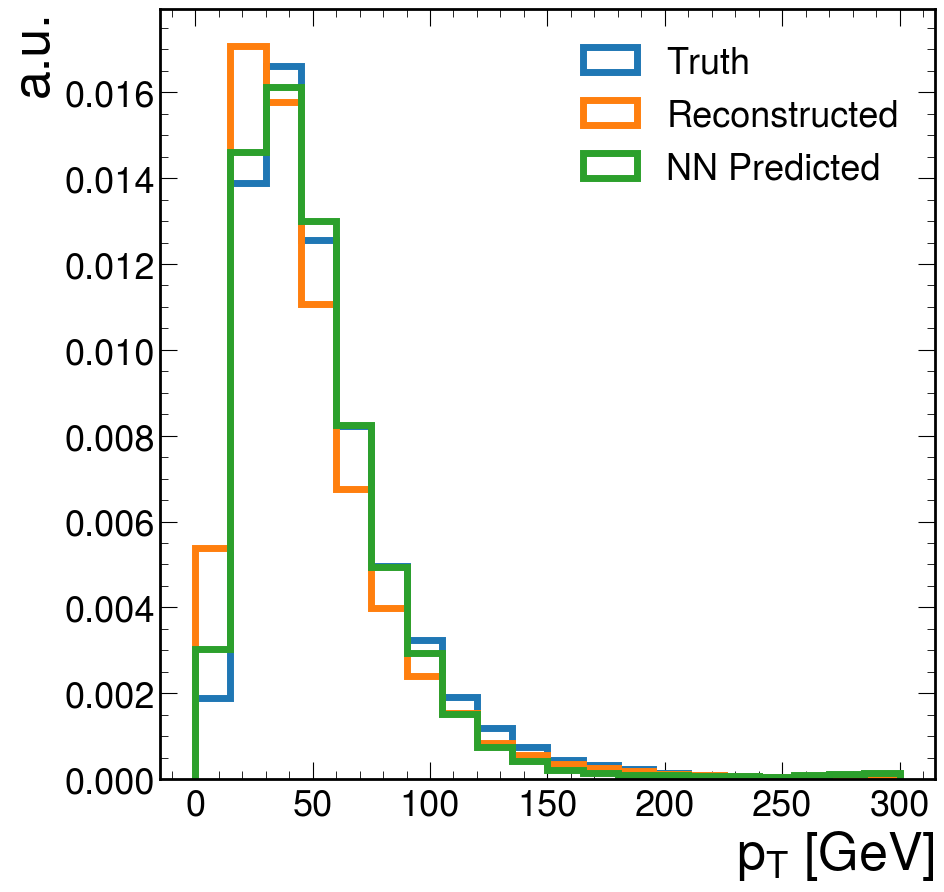

0.0
2043/2043 [==============================] - 1s 548us/step
[1.1457151  1.2495426  0.98158276 ... 1.328689   0.9726528  1.1731467 ]
[ 69.029335  48.419777 181.10202  ...  59.45883   70.76049   19.943495]


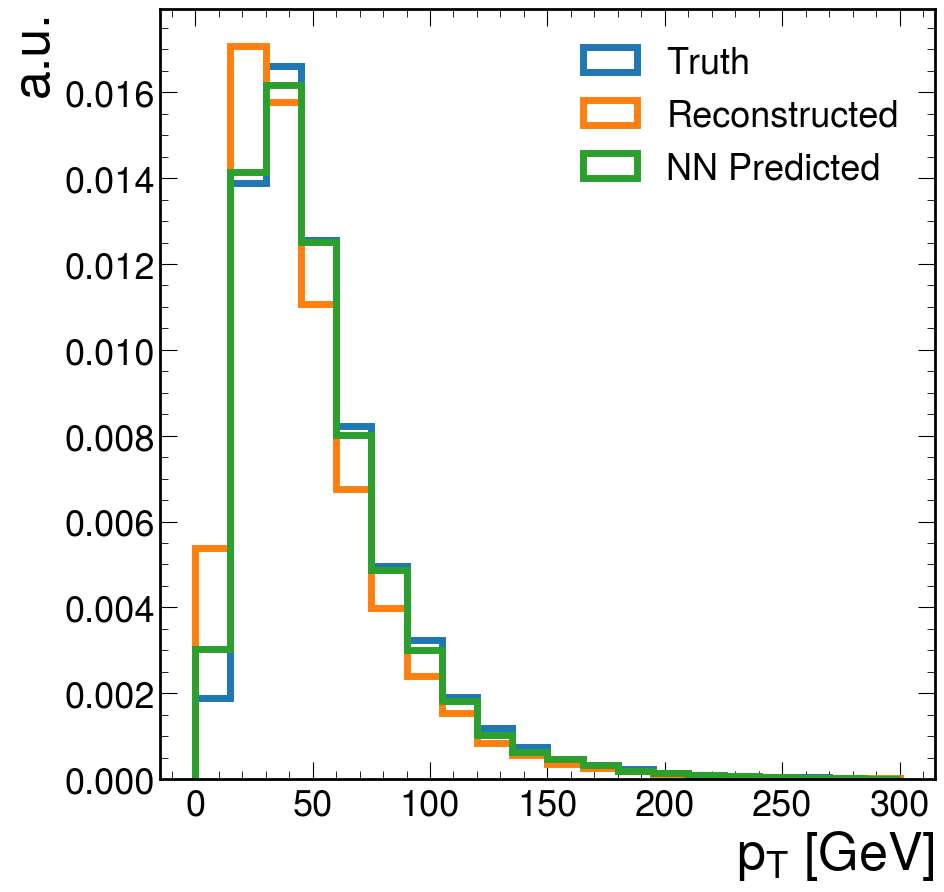

0.1111111111111111
2043/2043 [==============================] - 1s 531us/step
[1.1623701 1.1893835 0.904744  ... 1.2656558 1.013148  1.1580582]
[ 70.0328    46.08861  166.92528  ...  56.638096  73.70651   19.686989]


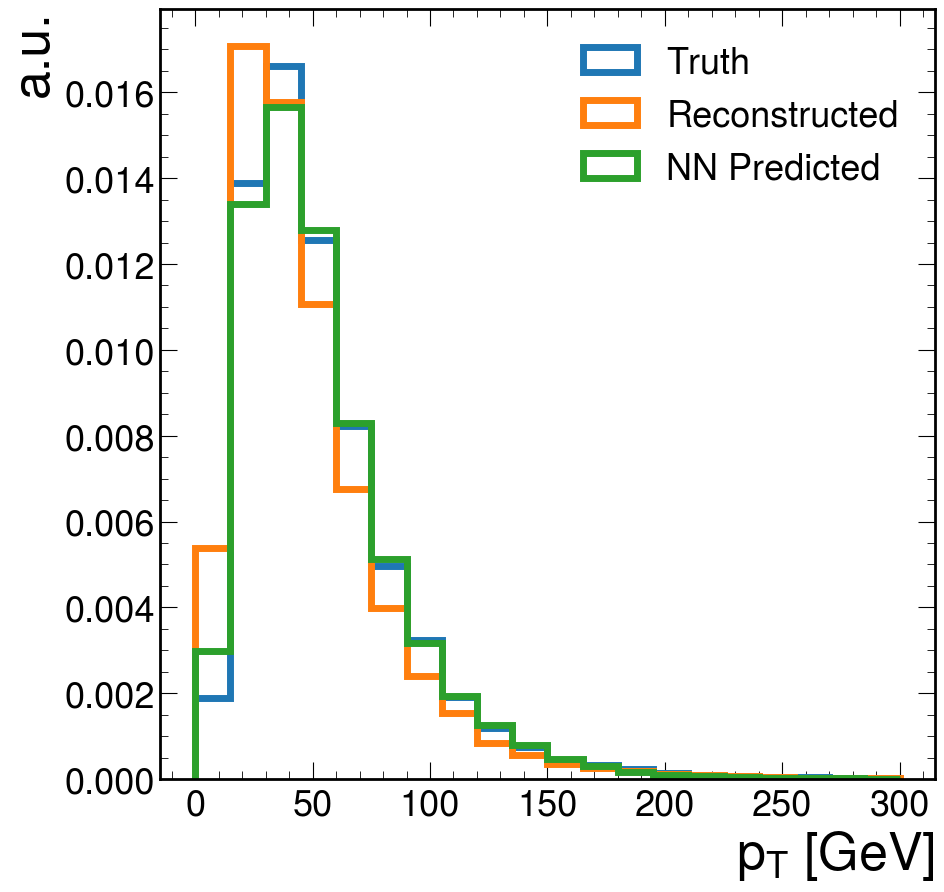

0.2222222222222222
2043/2043 [==============================] - 1s 548us/step
[1.0674323  1.1289424  0.97158515 ... 1.1478813  0.8861493  1.2348765 ]
[ 64.3128    43.746517 179.25746  ...  51.367687  64.46736   20.9929  ]


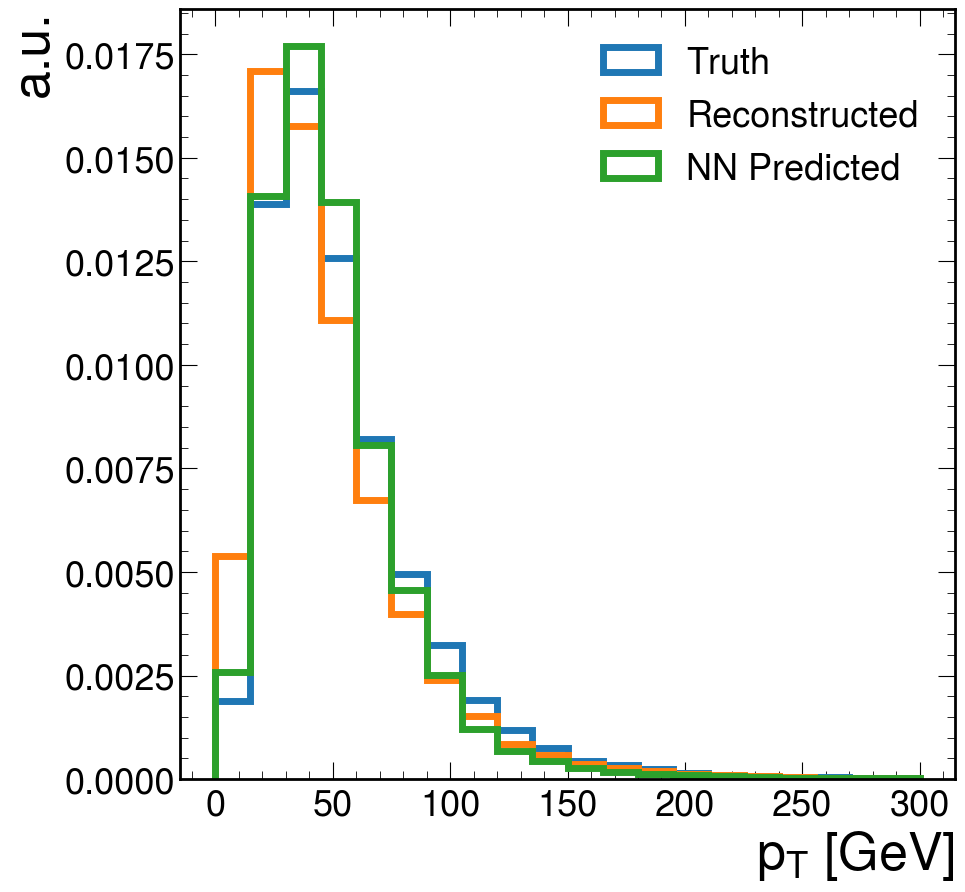

0.3333333333333333
2043/2043 [==============================] - 1s 522us/step
[1.1337049  1.2072661  0.7642817  ... 1.3207768  0.94119287 1.1150475 ]
[ 68.30572   46.781563 141.00998  ...  59.104763  68.47178   18.955807]


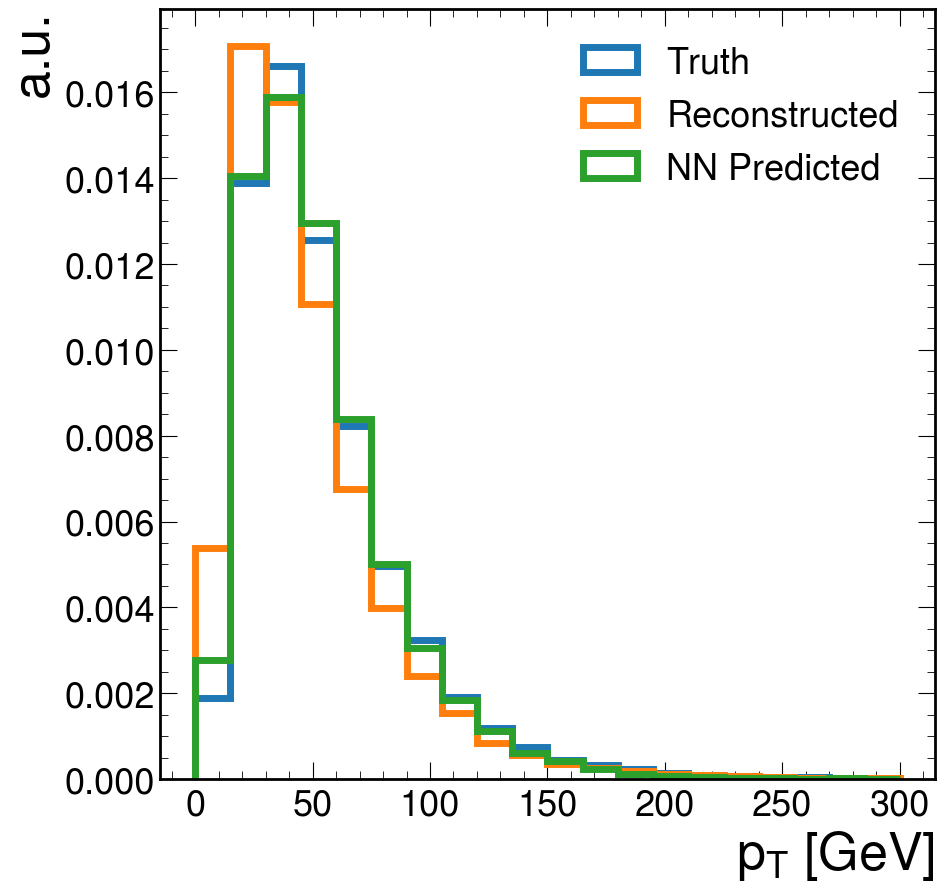

0.4444444444444444
2043/2043 [==============================] - 1s 514us/step
[1.2126886 1.2361839 1.2122068 ... 1.4204614 1.0965246 1.1938037]
[ 73.06448   47.902126 223.65216  ...  63.565647  79.77216   20.294662]


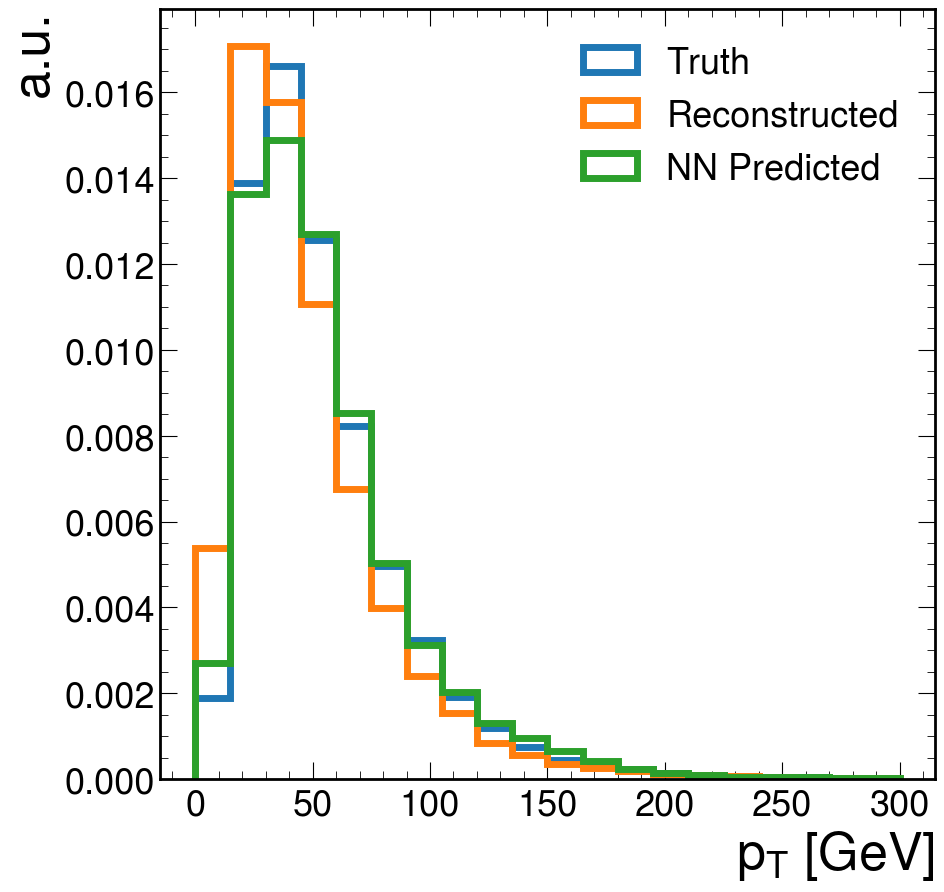

0.5555555555555556
2043/2043 [==============================] - 1s 605us/step
[1.2862188 1.3335729 1.2036521 ... 1.4557905 1.0915253 1.2558029]
[ 77.49468   51.67595  222.07382  ...  65.14663   79.40847   21.348648]


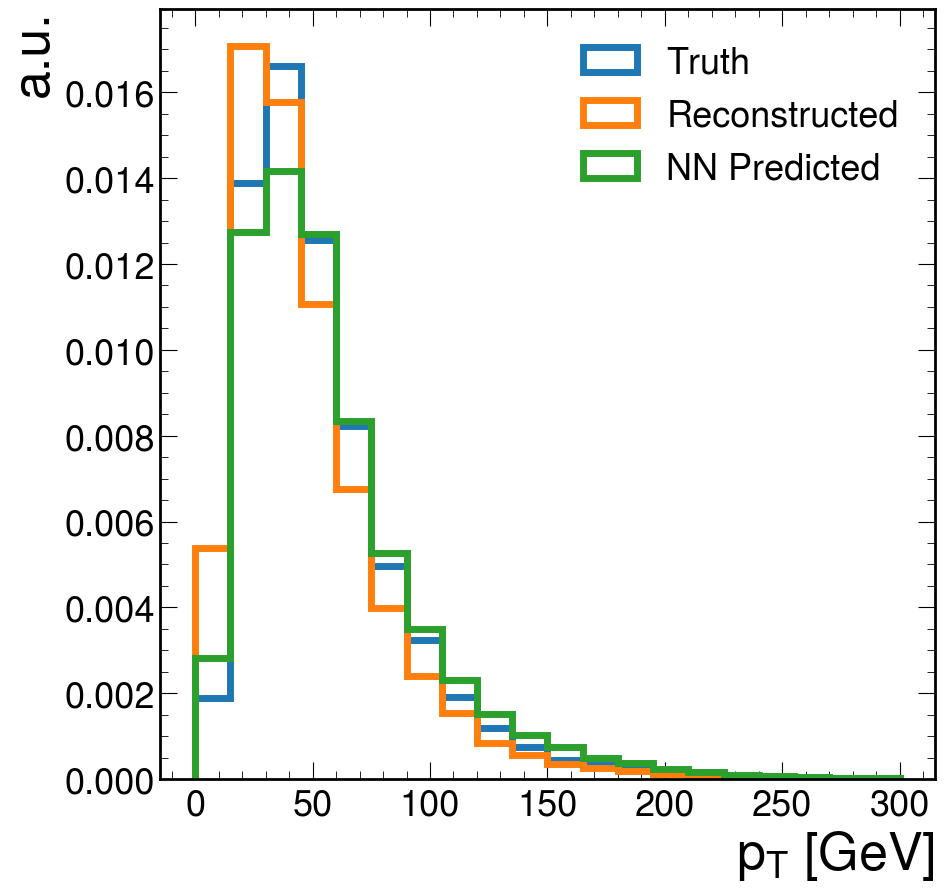

0.6666666666666666
2043/2043 [==============================] - 1s 515us/step
[1.0741452 1.3227725 0.9933869 ... 1.295809  1.0844077 1.2194169]
[ 64.71725   51.257435 183.27989  ...  57.987453  78.890656  20.730087]


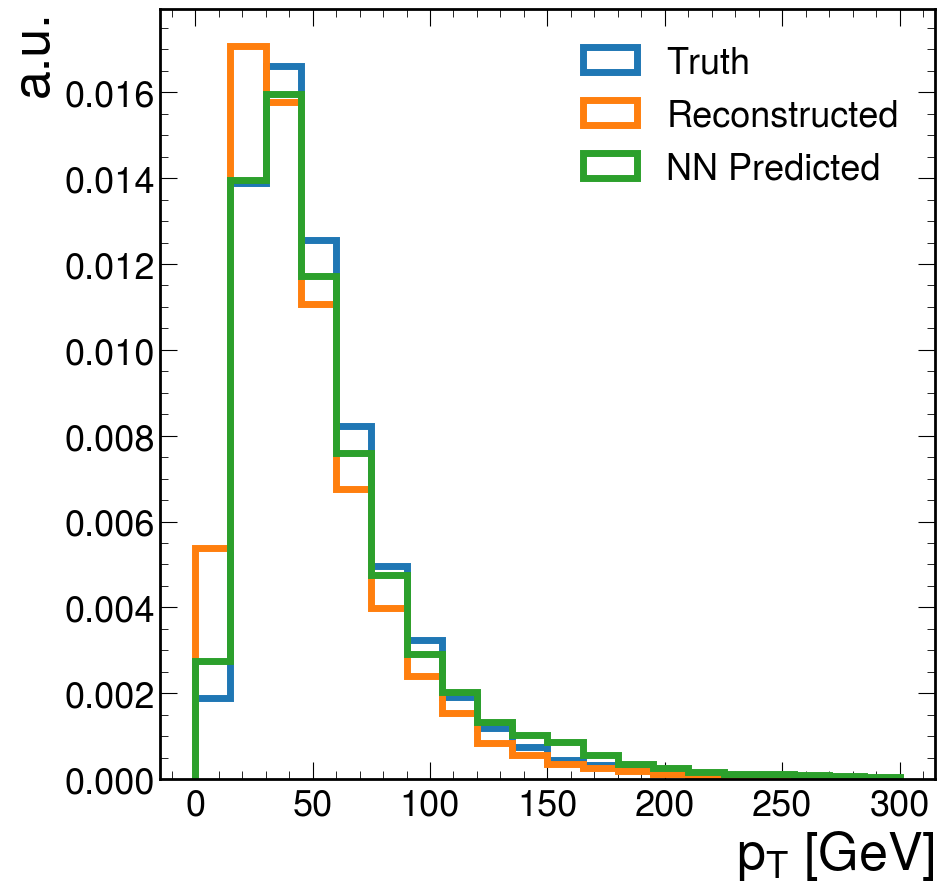

0.7777777777777777
2043/2043 [==============================] - 1s 512us/step
[1.0488557  1.3805302  1.1612413  ... 1.3137965  0.89855874 1.344782  ]
[ 63.193554  53.49555  214.24902  ...  58.792393  65.37015   22.861294]


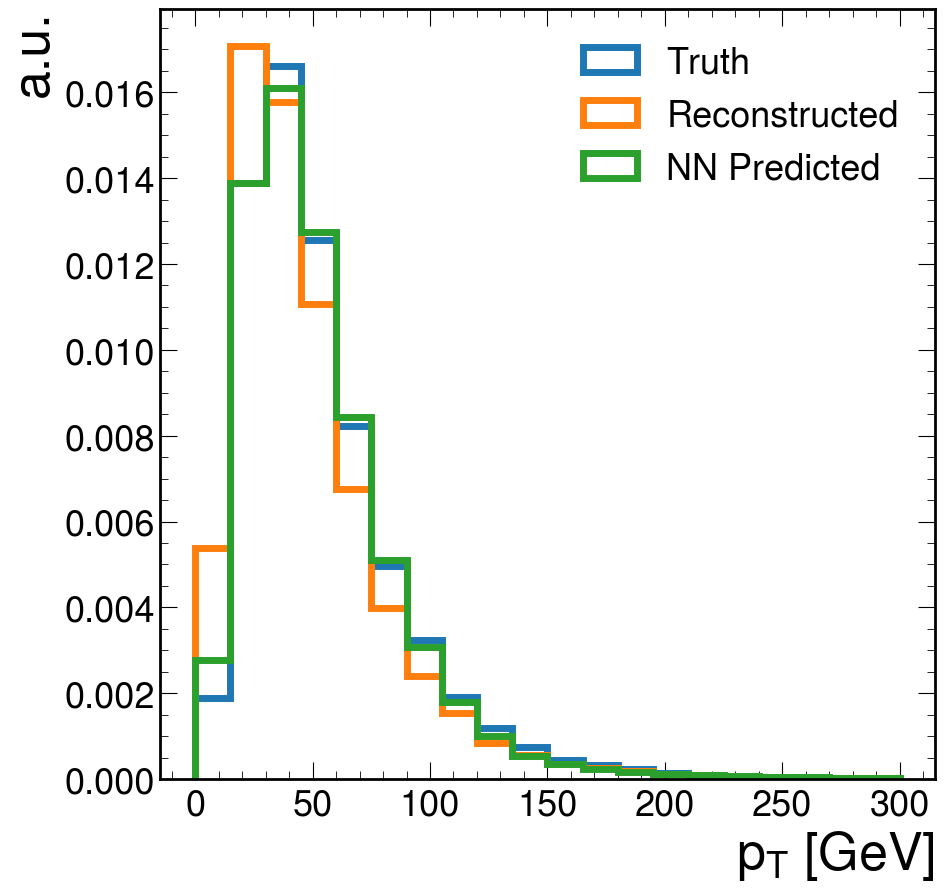

0.8888888888888888
2043/2043 [==============================] - 1s 527us/step
[-1.1343217 -2.1578803  4.1380296 ... -2.4298398  1.5674138 -2.3766222]
[ -68.34288   -83.61786   763.46643  ... -108.73534   114.02936
  -40.402576]


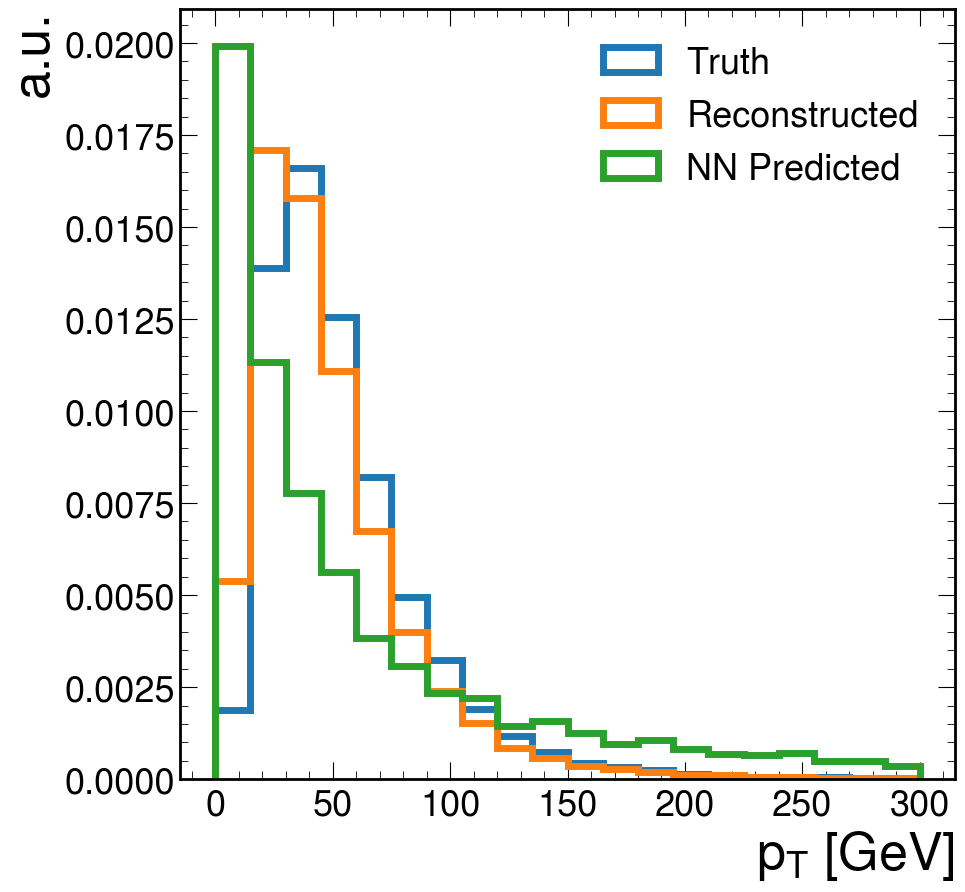

1.0


In [19]:
# load_and_predict_test("../../ntuples/Jan_25_2023", model)
for i in range(len(trained_models)):
    load_and_predict_test("../../ntuples/Jan_25_2023", trained_models[i])
    print(gammas[i])

In [20]:
# Looking nice!! 

## Scanning Optimal Gamma using ROC Curve

In [21]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
model_id = load_model(model_id_name)
#MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_regress = load_model(model_pt_regress_name)
#MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

In [22]:
def prep_rate_data(NormalModelID, 
                   ModelNameID,
             ModelNameRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(NormalModelID)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    #model_regress = load_model(ModelNameRegress)
    
    #minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    #minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    #true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    #true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    #sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    #minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    #true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    #minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    
    plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(len(ModelNameID)):
        modelID = ModelNameID[i]
        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        #
        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        #Now apply correction
    #     for i in range(len(ModelNameRegress)):
        #model_regress = load_model(ModelNameRegress)
        model_regress = ModelNameRegress[i]

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]

        plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Tau NN ID ($p_T$ Correction), $\gamma=$' + str(round(gammas[i], 1)),linewidth=2)
        hep.cms.text("Phase 2 Simulation")
        hep.cms.lumitext("PU 200 (14 TeV)")

        plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
        plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

        plt.yscale('log')
        #plt.legend(loc='best',fontsize=20)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.show()

    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 542us/step


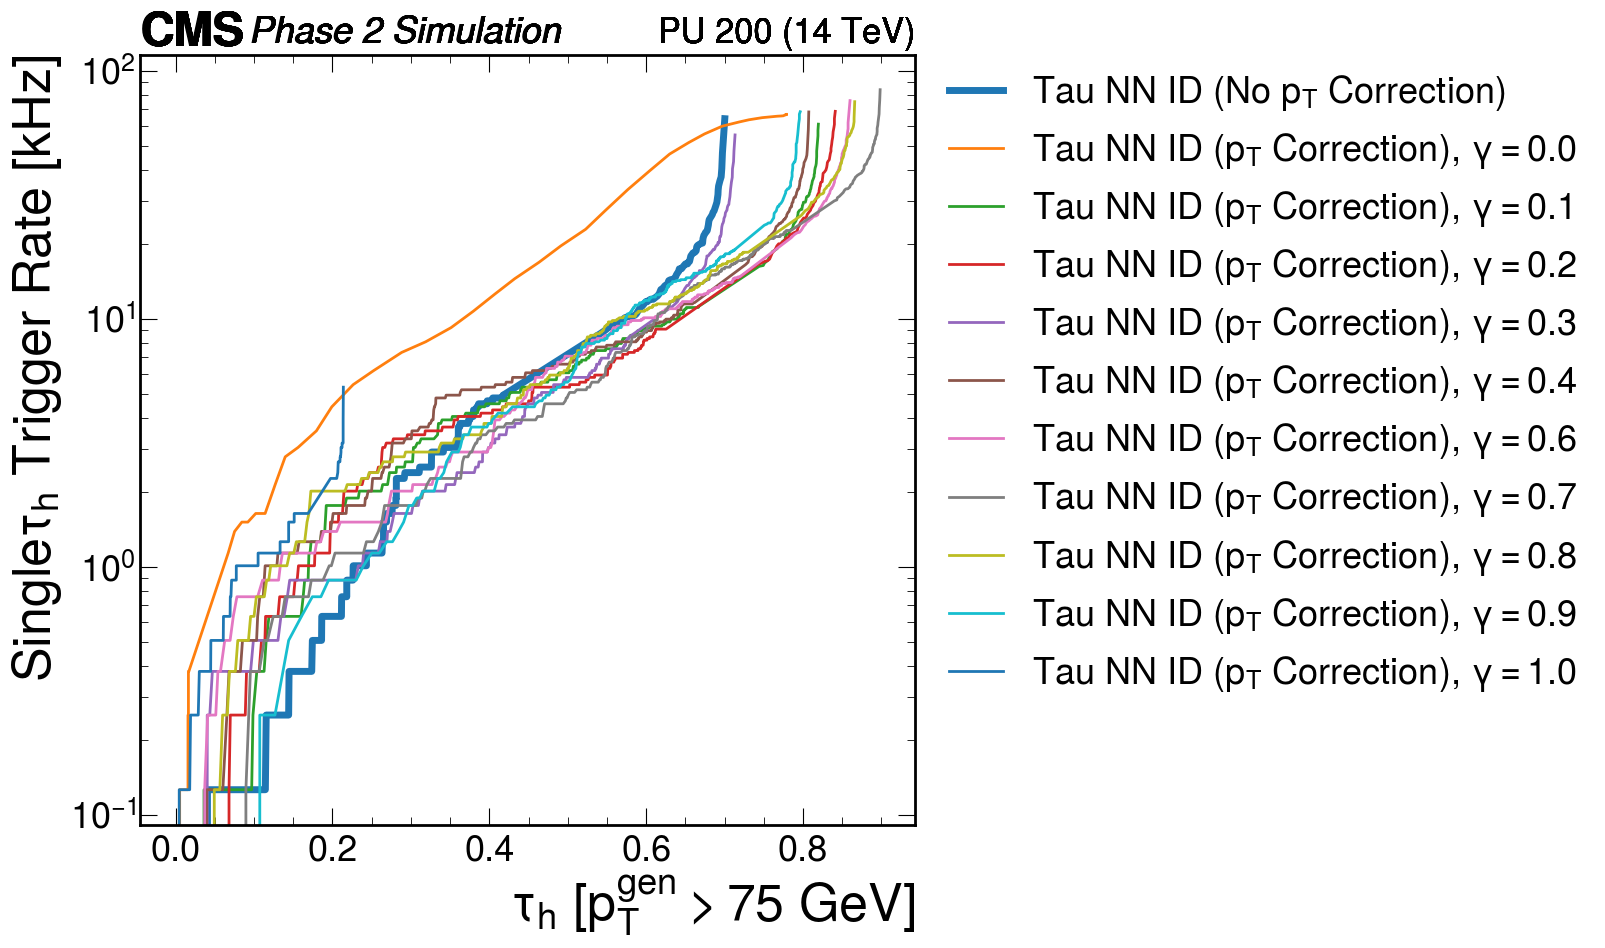

In [23]:
# n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
#                                                                                                                                     trained_models,
#                                                                                                                                     truth_sig_pt_cut=75,
#                                                                                                                                     minbias_pt_cut_value=75)

n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    trained_models,
                                                                                                                                    trained_models,
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)

## Optimal Gamma using different ROC Curve

11371/11371 [==============================] - 6s 526us/step
[[0.5218929 ]
 [0.59139323]
 [0.8427133 ]
 ...
 [0.6998029 ]
 [0.44387916]
 [0.5543336 ]]
11371/11371 [==============================] - 6s 512us/step
[[0.9969458 ]
 [0.960869  ]
 [0.97324276]
 ...
 [0.01301915]
 [0.5497987 ]
 [0.46674094]]
11371/11371 [==============================] - 6s 525us/step
[[0.9961105 ]
 [0.970962  ]
 [0.96266216]
 ...
 [0.01052618]
 [0.407603  ]
 [0.40149942]]
11371/11371 [==============================] - 6s 510us/step
[[0.9973082 ]
 [0.9718252 ]
 [0.965267  ]
 ...
 [0.01487383]
 [0.5130905 ]
 [0.46226543]]
11371/11371 [==============================] - 6s 535us/step
[[0.9967362 ]
 [0.9456154 ]
 [0.9733369 ]
 ...
 [0.00994596]
 [0.48931026]
 [0.4127476 ]]
11371/11371 [==============================] - 6s 545us/step
[[0.99619395]
 [0.9647875 ]
 [0.92949885]
 ...
 [0.01773844]
 [0.30905697]
 [0.40209836]]
11371/11371 [==============================] - 6s 516us/step
[[0.9966503 ]
 [0.95997244]
 [0.9

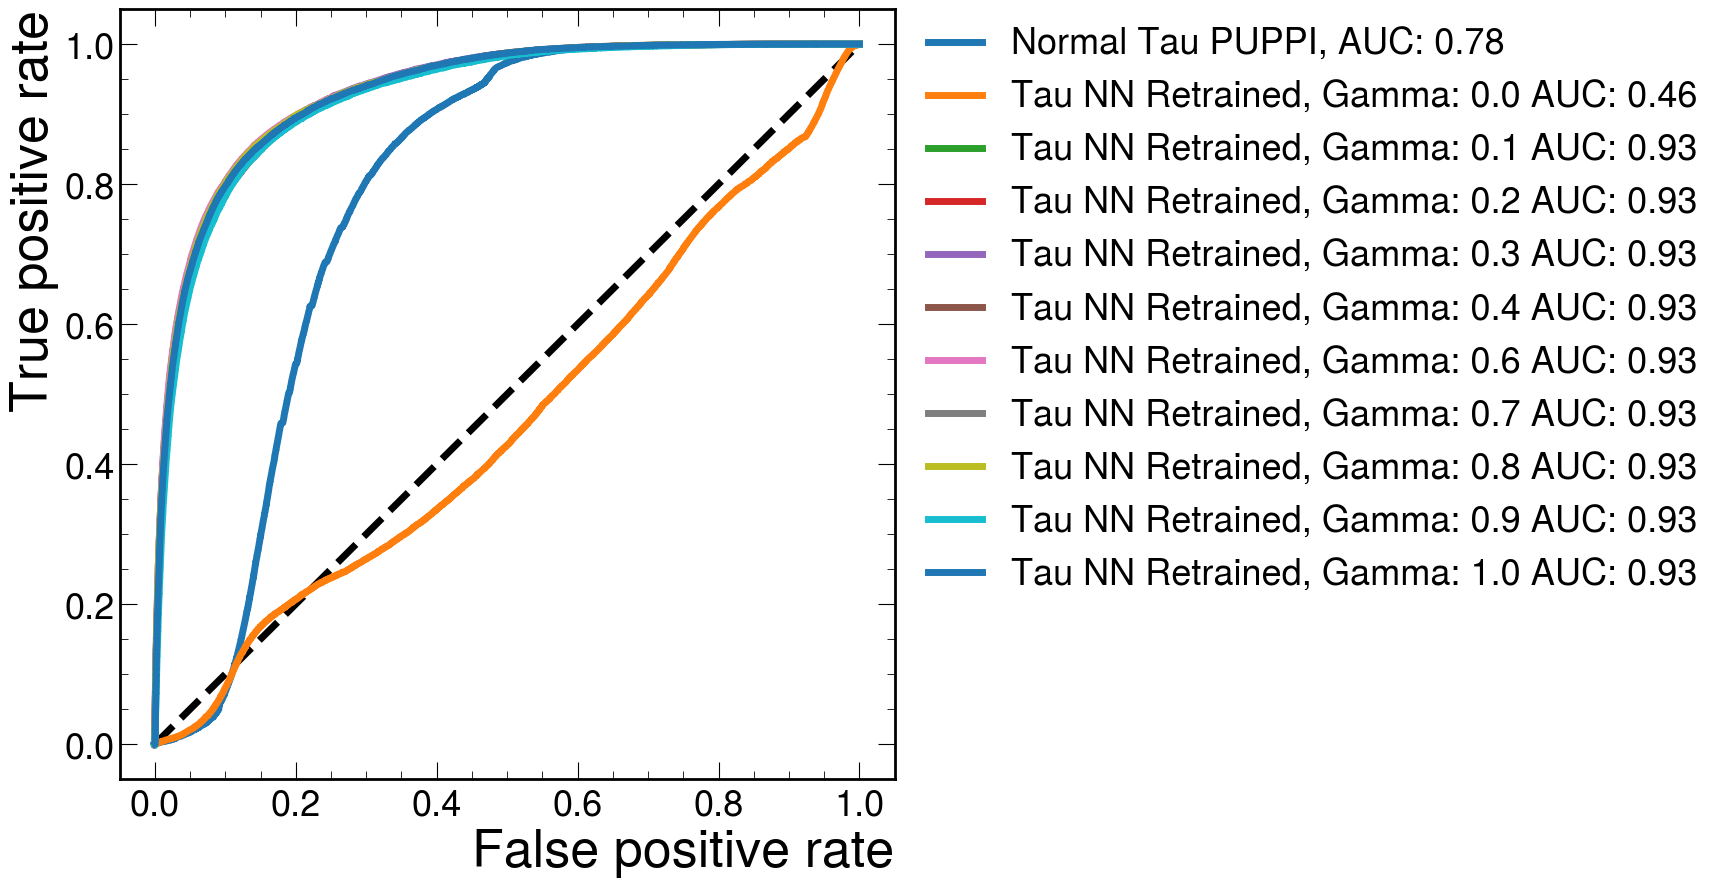

In [24]:
NormalModel = load_model('../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5')
#model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
# model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
# #model_id = load_model(model_id_name)
# model_train_id = load_model(model_pt_regress_name)


y_pred_normal = NormalModel.predict(X_test)
fpr_normal, tpr_normal, _ = roc_curve(y_test_jetID,y_pred_normal)
#     auc_score_normal = round(auc(fpr_normal, tpr_normal),2)
auc_score_normal = round(auc(fpr_normal, tpr_normal), 2)
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_normal, tpr_normal, label = 'Normal Tau PUPPI, AUC: {}'.format(auc_score_normal))
#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

    
for i in range(len(trained_models)):
    y_pred_mono = trained_models[i].predict(X_test)[0]
    print(y_pred_mono)
    fpr_mono, tpr_mono, _ = roc_curve(y_test_jetID, y_pred_mono)
#     auc_score_mono = round(auc(fpr_mono, tpr_mono),2)
    auc_score_mono = round(auc(fpr_mono, tpr_mono), 2)



   
    plt.plot(fpr_mono, tpr_mono, label = 'Tau NN Retrained, Gamma: ' + str(round(gammas[i], 1)) + ' AUC: {}'.format(auc_score_mono))

  
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Resolution + Response Plots

In [25]:
def bob(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test)[1].flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))
    
    plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()
    plt.show()


2043/2043 [==============================] - 1s 548us/step
-564.7084
4633.0806
Error for parameter esimations:  [0.00172467 0.2550148  0.22052775]
Standard deviation (fit) is 8.105963859136363
Mean (fit) is -1.534388129874853


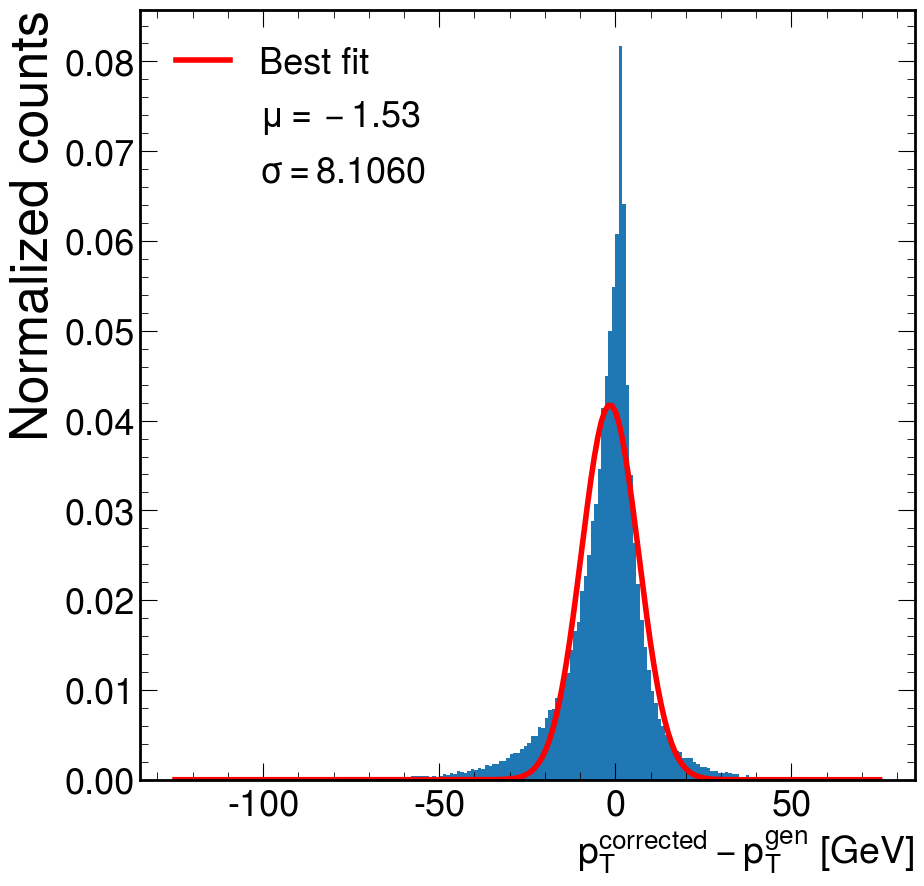

0.0
2043/2043 [==============================] - 1s 515us/step
-696.9822
4469.859
Error for parameter esimations:  [0.00177748 0.24315663 0.21309836]
Standard deviation (fit) is 7.8262208907501245
Mean (fit) is -0.7348347719762344


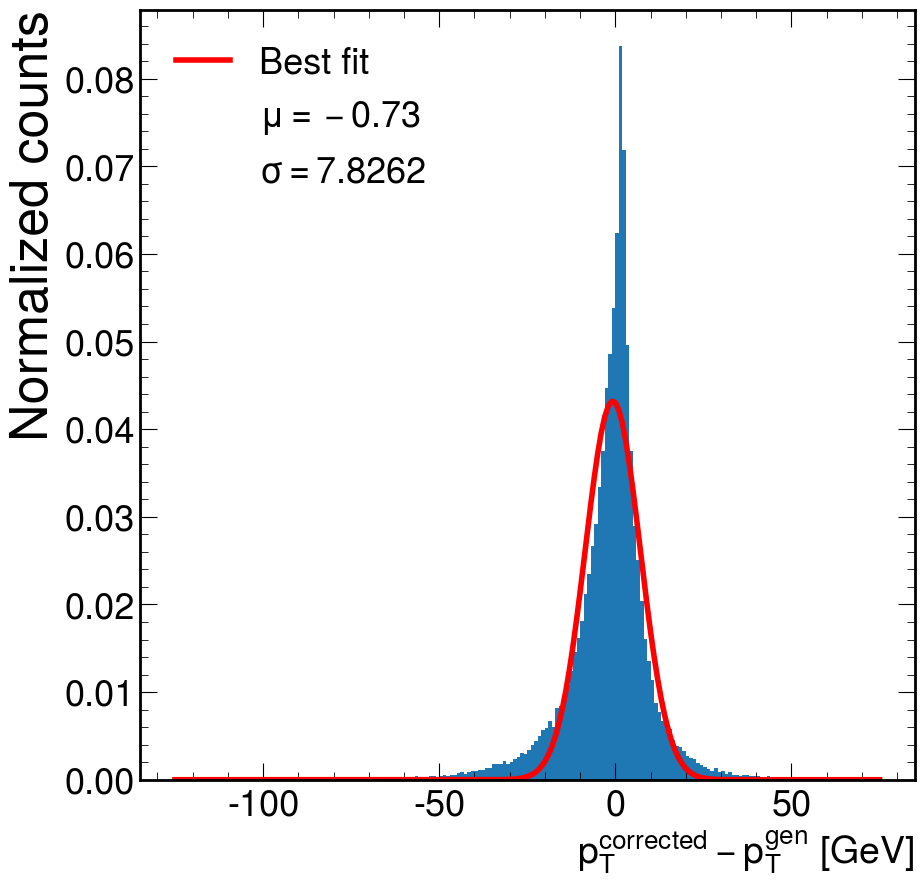

0.1111111111111111
2043/2043 [==============================] - 1s 516us/step
-681.46204
4393.443
Error for parameter esimations:  [0.00167979 0.24308546 0.21361908]
Standard deviation (fit) is 8.104585025318405
Mean (fit) is 0.3211798450884856


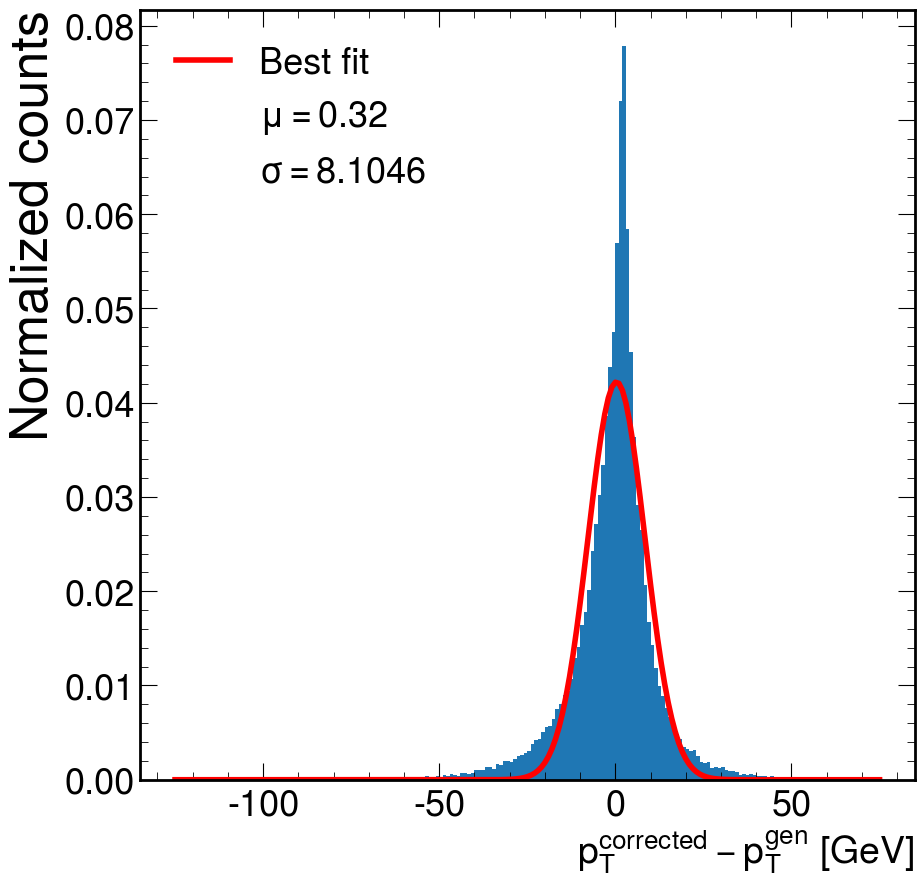

0.2222222222222222
2043/2043 [==============================] - 1s 514us/step
-697.68713
4715.2075
Error for parameter esimations:  [0.00156751 0.24116035 0.20083126]
Standard deviation (fit) is 8.24748476636253
Mean (fit) is -2.6449196262550765


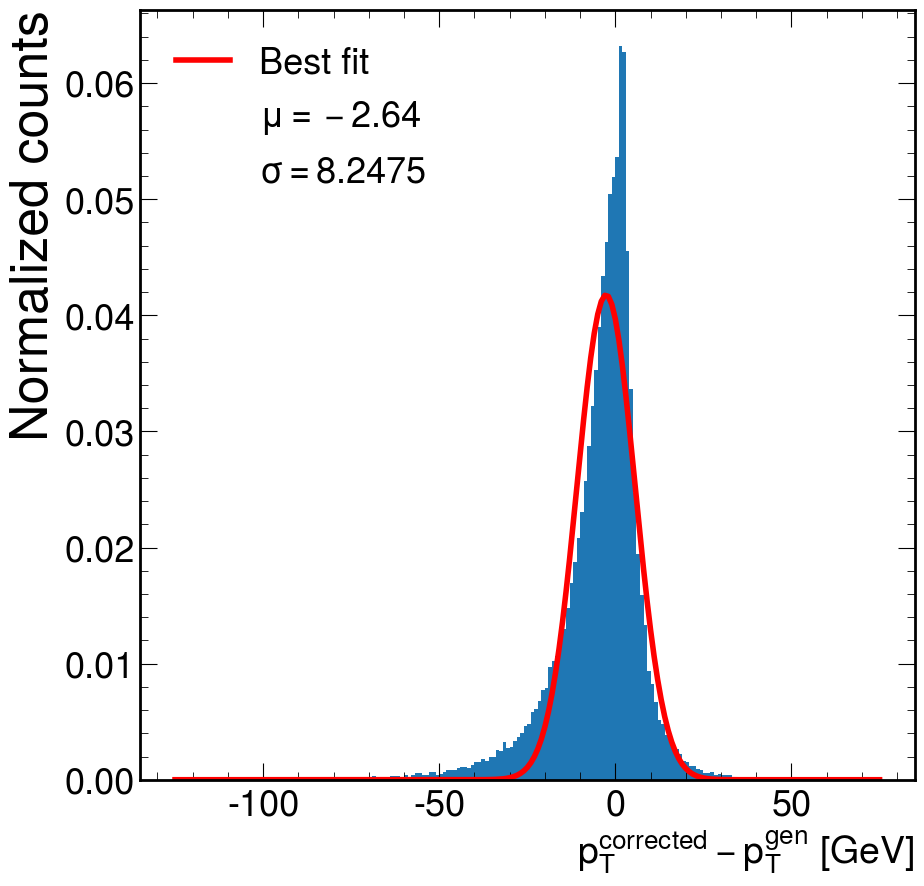

0.3333333333333333
2043/2043 [==============================] - 1s 511us/step
-594.93945
4421.6304
Error for parameter esimations:  [0.00165957 0.24212327 0.21192716]
Standard deviation (fit) is 8.116685345851527
Mean (fit) is -0.7211059973156869


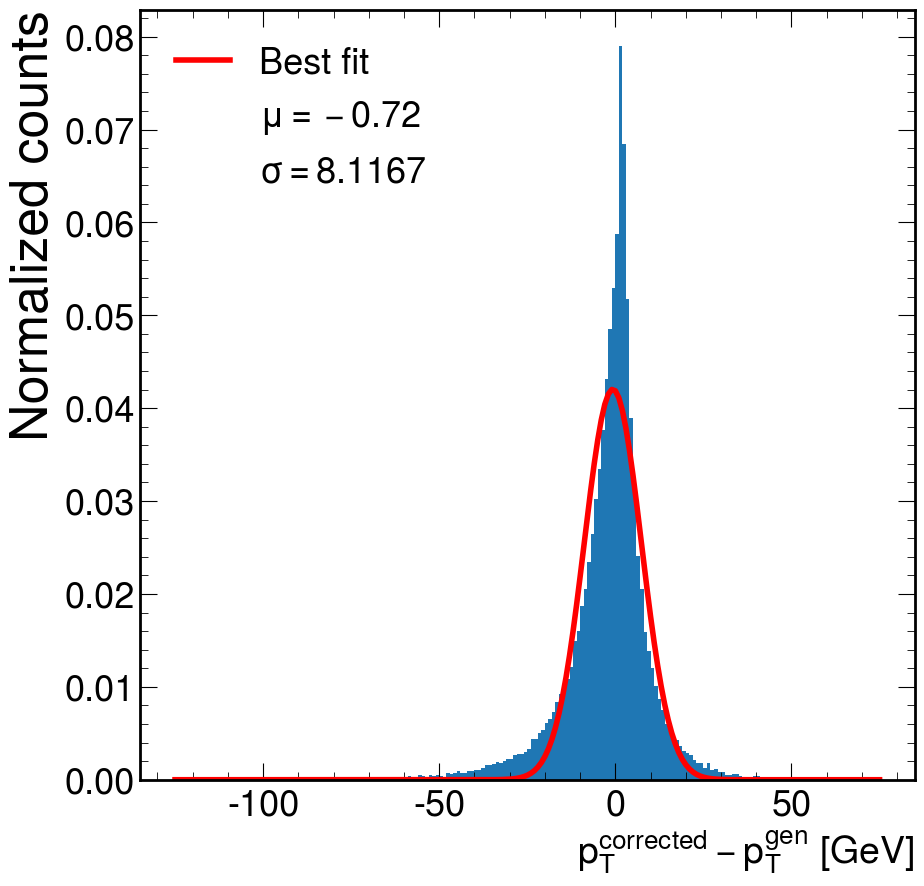

0.4444444444444444
2043/2043 [==============================] - 1s 511us/step
-591.66394
4684.838
Error for parameter esimations:  [0.00154068 0.24862664 0.21838999]
Standard deviation (fit) is 8.611772437192302
Mean (fit) is 1.5257250859372646


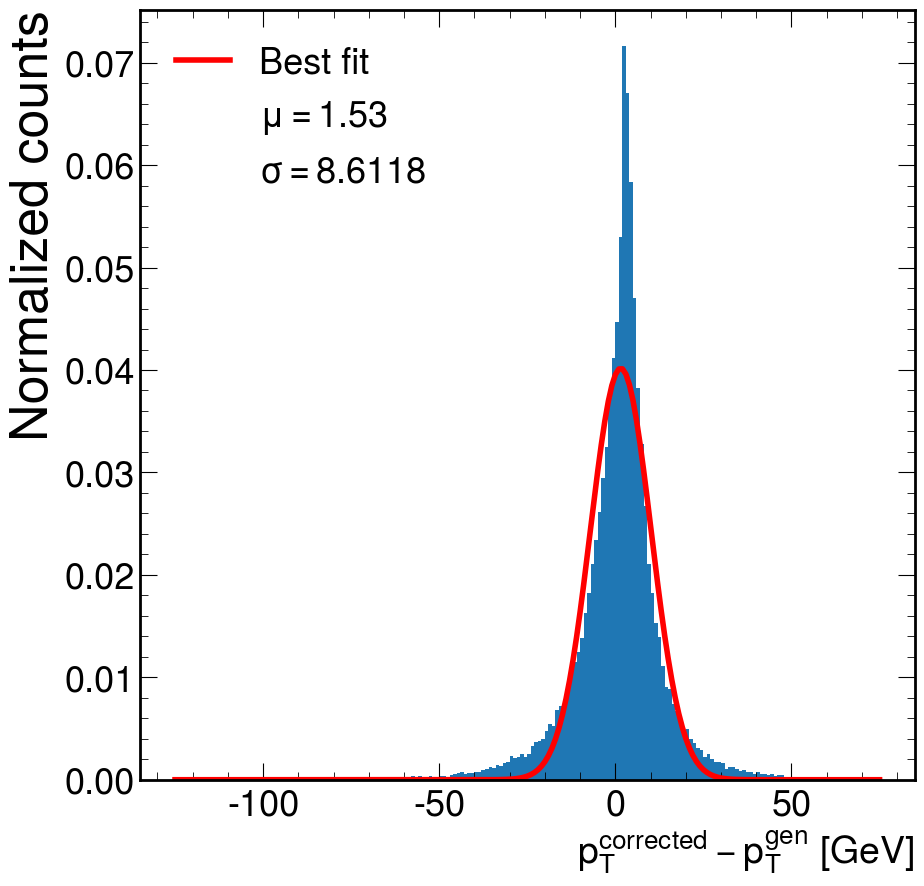

0.5555555555555556
2043/2043 [==============================] - 1s 514us/step
-738.0991
4232.8823
Error for parameter esimations:  [0.00131817 0.26842857 0.23714885]
Standard deviation (fit) is 9.758062844654699
Mean (fit) is 3.4550805621702096


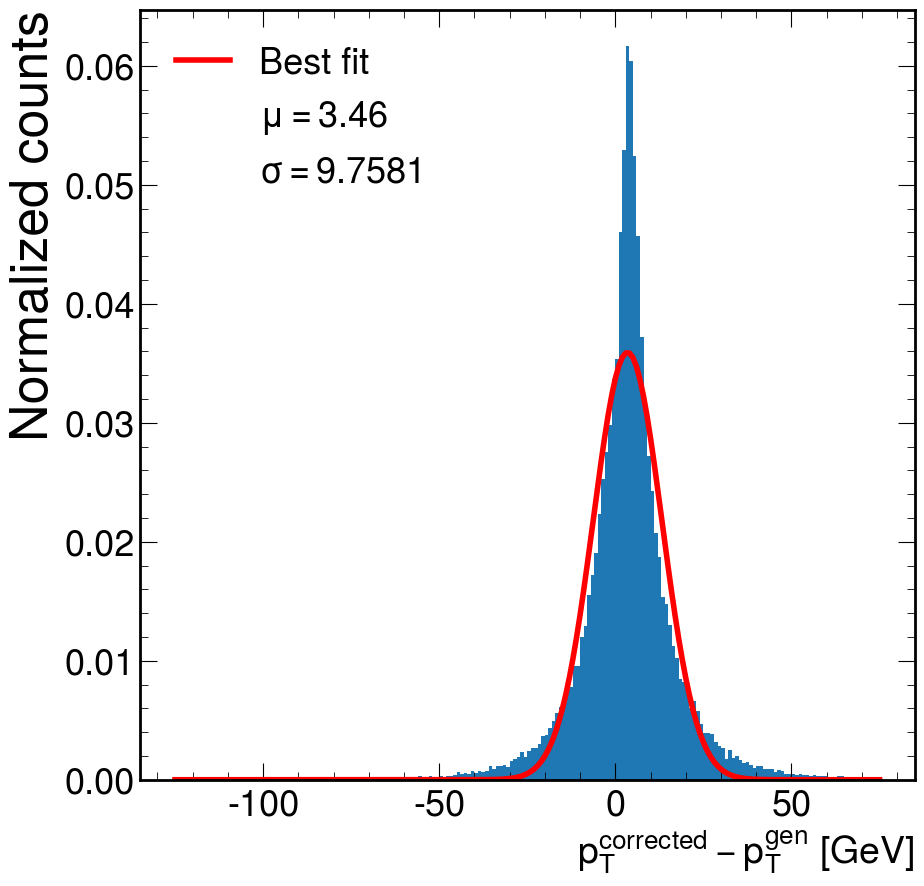

0.6666666666666666
2043/2043 [==============================] - 1s 509us/step
-1392.4178
4519.9834
Error for parameter esimations:  [0.00147607 0.27826699 0.24876625]
Standard deviation (fit) is 9.29947929613803
Mean (fit) is 1.3088226297205936


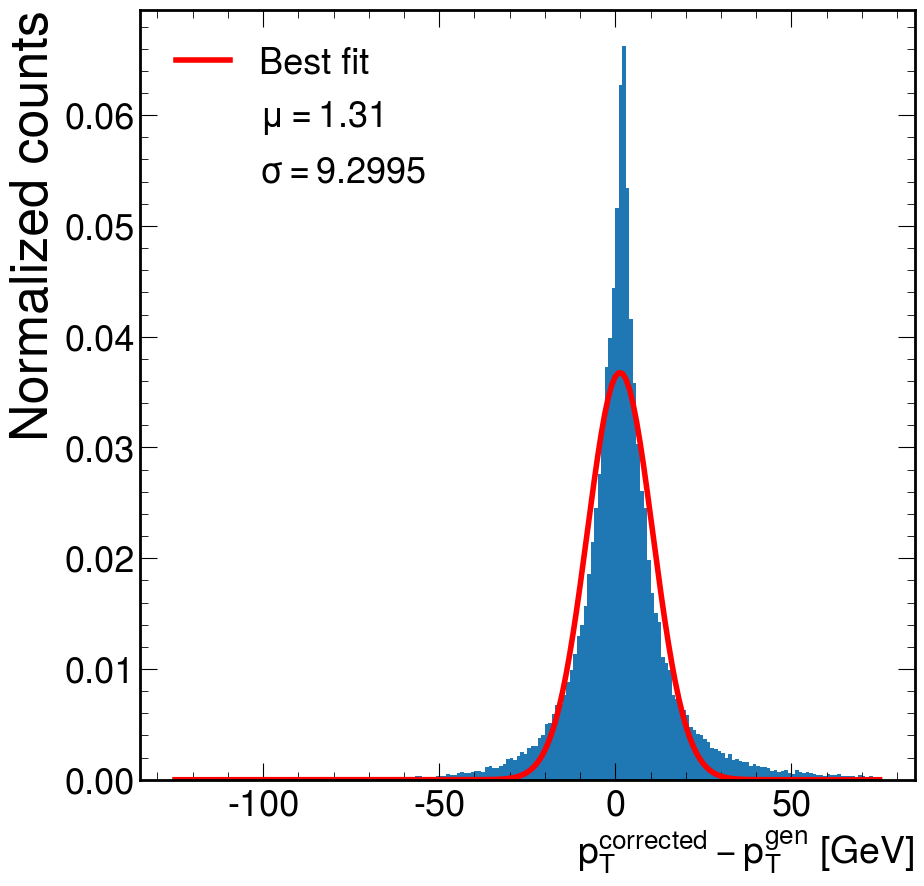

0.7777777777777777
2043/2043 [==============================] - 1s 513us/step
-607.0586
3835.4836
Error for parameter esimations:  [0.00140496 0.26299487 0.22903025]
Standard deviation (fit) is 9.274644956364302
Mean (fit) is -0.5868771469718119


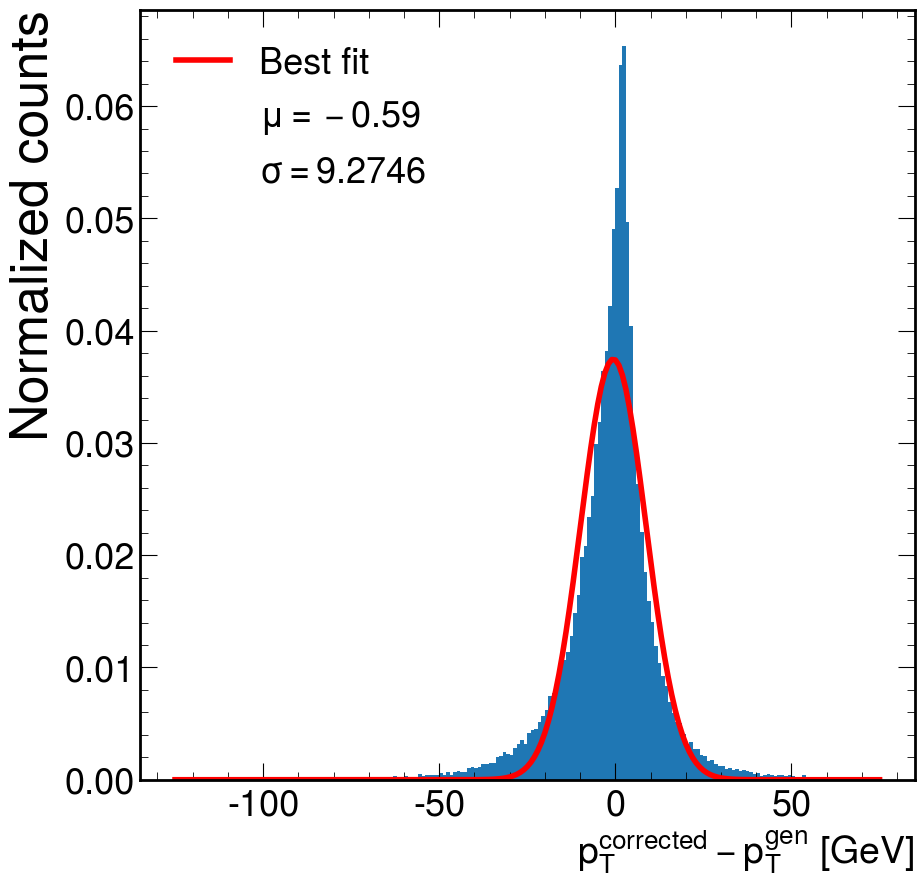

0.8888888888888888
2043/2043 [==============================] - 1s 514us/step
-5902.193
8784.158
Error for parameter esimations:  [2.71574978e-04 9.73020131e-01 8.07867369e-01]
Standard deviation (fit) is 37.53496301241458
Mean (fit) is -62.1679316619575


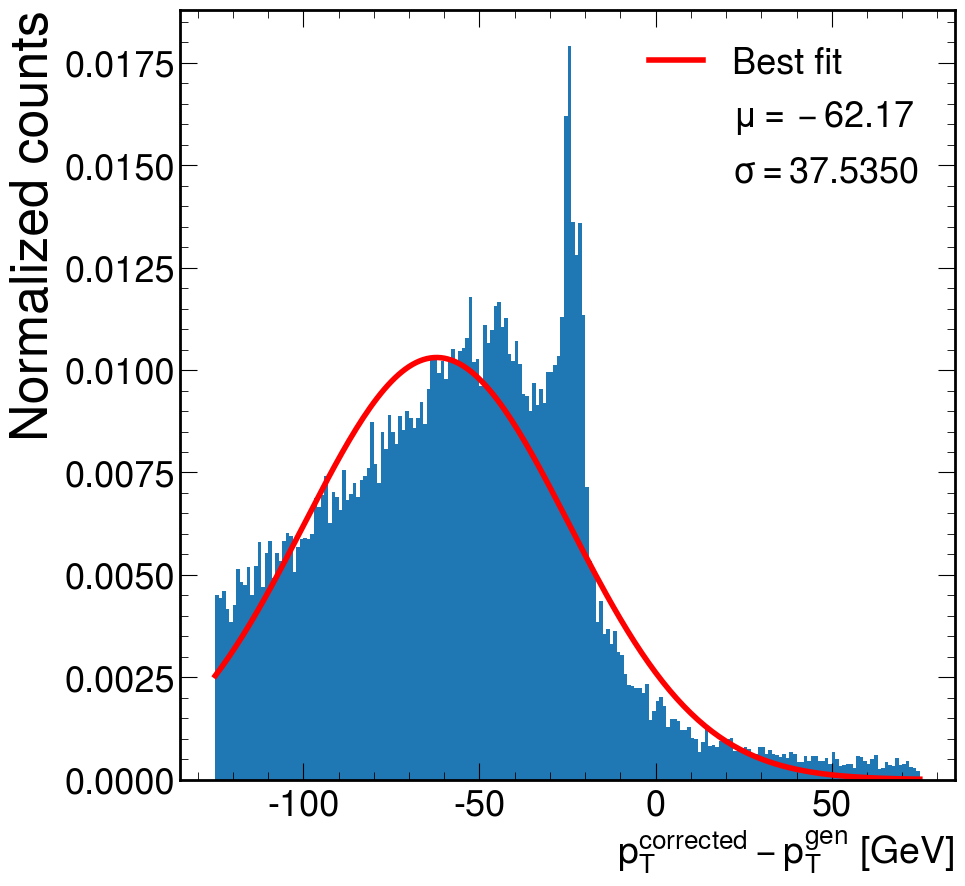

1.0


In [26]:
for i in range(len(trained_models)):
    bob("../../ntuples/Jan_25_2023", trained_models[i])
    print(gammas[i])

In [29]:
#trained_models[8].save('../models/merged_8_gamma88.h5')

In [28]:
#print(trained_models[8])